1- Decision Tree Implementation

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import inf

wine = pd.read_csv('./winequality-red.csv',sep=";")
#Adding the column quality_binary with 0=low_quality [0-4] and 1=high_quality [5-9]
wine["quality_binary"] = (wine["quality"] >= 5).astype(int)
y = wine["quality_binary"]
xFeat =  wine.iloc[:, 0:10]
print(y.head())
print(xFeat.head())


#split into training and testing sets
n = round(len(y)*0.7)
x_train = xFeat.iloc[0:n,:]
x_test = xFeat.iloc[n:,:]
y_train = y[0:n]
y_test = y[n:]


0    1
1    1
2    1
3    1
4    1
Name: quality_binary, dtype: int64
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  
0                 11.0                  34.0   0.9978  3.51       0.56  
1                 25.0                  67.0   0.9968  3.20       0.68  
2                 15.0                  54.0   0.9970  3.26       0.65  
3                 17.0                  60.0   0.9980  3.16       0.58  
4                 11.0                  34.0   0.9978  3.51       0.56  


In [3]:
def split(xFeat, y):
  best_feature = None
  best_value = None
  best_impurity = inf
  #choose a feature
  for i in range(xFeat.shape[1]):
    values = np.unique(xFeat.iloc[:, i])
    for value in values:
      #choose value
      y_left = y[xFeat.iloc[:, i] < value]
      y_right = y[xFeat.iloc[:, i] >= value]

      if len(y_left) == 0 or len(y_right) == 0:
                    continue  # Skip if one of the splits is empty
      #Get impurity for each side:
      impurity_left = get_impurity(y_left)
      impurity_right = get_impurity(y_right)
      total_impurity = (len(y_left) * impurity_left + len(y_right) * impurity_right) / len(y)

      if total_impurity < best_impurity:
        best_feature = i
        best_value = value
        best_impurity = total_impurity

  return best_feature,best_value

def get_impurity(y):
    n = len(y) #number of nodes in the region
    if n == 0:
      return 0.5

    p1 = sum(y) / n  # Proportion of class 1
    p0 = 1 - p1  # Proportion of class 0
    gini = 1 - (p0**2 + p1**2)  # Gini impurity
    return gini


def get_accuracy(y_pred, y):
  correct = 0
  for i in range(len(y_pred)):
    if y_pred[i] == y.iloc[i]:
      correct += 1

  return correct/len(y)

class Node():
  def __init__(self,best_feature=None, best_value=None, left_subtree=None, right_subtree=None, label = None):
    self.value = best_value
    self.feature = best_feature
    self.left_child = left_subtree
    self.right_child = right_subtree
    self.label = label


class Tree():
  def __init__(self,xFeat, y,max_depth = 5,min_samples_split=2):
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split
    self.root = None

  def build_tree(self, xFeat, y, curr_depth=0):

    num_samples = xFeat.shape[0]
    num_classes = len(np.unique(y))

    # split until stopping conditions are met
    if (curr_depth >= self.max_depth or
        num_samples < self.min_samples_split or #not enough nodes in the region
        num_classes == 1): #max purity in the region
        leaf_class = np.argmax(np.bincount(y))  #majority class
        return Node(label=leaf_class)

    best_feature,best_value = split(xFeat, y)
    left_indices = xFeat.iloc[:, best_feature] < best_value
    right_indices = xFeat.iloc[:, best_feature] >= best_value

    # left
    left_subtree = self.build_tree(xFeat[left_indices],y[left_indices], curr_depth+1)
    # right
    right_subtree = self.build_tree(xFeat[right_indices],y[right_indices], curr_depth+1)
    # return decision node
    return Node(best_feature, best_value, left_subtree, right_subtree)

  def train(self, xFeat, y):
    self.root = self.build_tree(xFeat, y)
    return

  def predict(self, xFeat):
    #predicted classes
    labels = [self.predict_sample(sample,self.root) for index, sample in xFeat.iterrows()]

    return labels

  def predict_sample(self, sample, node):
    if node.label is not None:  # Leaf node
      return node.label
    if sample[node.feature] < node.value:
      return self.predict_sample(sample, node.left_child)
    else:
      return self.predict_sample(sample, node.right_child)



In [ ]:
# a)
#tree = Tree(xFeat, y, max_depth = 5,min_samples_split=2)
#tree.train(xFeat, y)
# b)
#y_pred = tree.predict(xFeat[0:10])
# c)
#Training on different max_depth and min_samples
#Plot: max_depth = x, min_samples = y, accuracy = z
max_depth = list(range(1, 7))  # 1 to 6
min_samples = list(range(1, 16))  # 1 to 15
accuracy_train = np.zeros((len(max_depth), len(min_samples)))
accuracy_test = np.zeros((len(max_depth), len(min_samples)))

for i, depth in enumerate(max_depth):
  for j, samples in enumerate(min_samples):
    tree = Tree(x_train, y_train, max_depth = depth,min_samples_split=samples)
    tree.train(x_train, y_train)
    y_pred_train = tree.predict(x_train)
    y_pred_test = tree.predict(x_test)
    accuracy_train[i,j] = get_accuracy(y_pred_train,y_train)
    accuracy_test[i,j] = get_accuracy(y_pred_test,y_test)




<ipython-input-3-d29767a4e580>:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if sample[node.feature] < node.value:


[[0.96693476 0.96693476 0.96693476 0.96693476 0.96693476 0.96693476
  0.96693476 0.96693476 0.96693476 0.96693476 0.96693476 0.96693476
  0.96693476 0.96693476 0.96693476]
 [0.96961573 0.96961573 0.96961573 0.96961573 0.96961573 0.96961573
  0.96961573 0.96961573 0.96961573 0.96961573 0.96961573 0.96961573
  0.96961573 0.96961573 0.96961573]
 [0.97229669 0.97229669 0.97229669 0.97229669 0.97229669 0.97229669
  0.97229669 0.97229669 0.97229669 0.97229669 0.97050938 0.97050938
  0.97050938 0.97050938 0.97050938]
 [0.97587131 0.97587131 0.97587131 0.97587131 0.97587131 0.97587131
  0.97497766 0.97497766 0.97497766 0.97497766 0.97319035 0.97319035
  0.97319035 0.97319035 0.97050938]
 [0.97944593 0.97944593 0.97944593 0.97765862 0.97765862 0.97765862
  0.97676497 0.97676497 0.97676497 0.97676497 0.97497766 0.974084
  0.974084   0.974084   0.97140304]
 [0.98302055 0.98302055 0.98302055 0.98033959 0.98033959 0.98033959
  0.97855228 0.97676497 0.97676497 0.97676497 0.97497766 0.974084
  0.9740

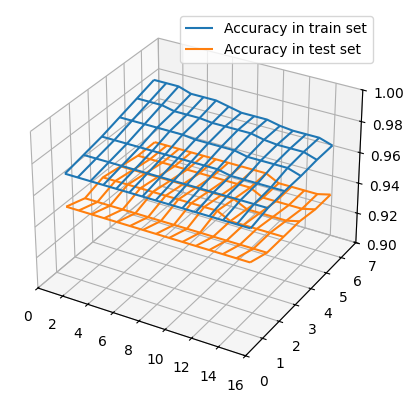

In [ ]:
max_depth = list(range(1, 7))  # 1 to 6
min_samples = list(range(1, 16))  # 1 to 15
X, Y = np.meshgrid(min_samples,max_depth)
print( accuracy_train,accuracy_test)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_wireframe(X, Y, accuracy_train, color='C0')
ax.plot_wireframe(X, Y, accuracy_test, color='C1', axlim_clip=True)
ax.set(xlim=(0, 16), ylim=(0, 7), zlim=(0.9, 1))
ax.legend(['Accuracy in train set', 'Accuracy in test set'])

plt.show()

2- Exploring Model Assessment Strategies

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn import metrics
import time

def holdout(model, xFeat, y, testSize):
  start = time.perf_counter()
  x_train, x_test, y_train, y_test = model_selection.train_test_split(xFeat, y, test_size=testSize, random_state=99)
  model.fit(x_train, y_train)
  y_pred_test = model.predict(x_test)
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test)
  testAuc = metrics.auc(fpr, tpr)
  y_pred_train =  model.predict(x_train)
  fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train)
  trainAuc = metrics.auc(fpr, tpr)

  end = time.perf_counter()
  timeElapsed = end - start
  return trainAuc, testAuc, timeElapsed



In [ ]:
max_depth = 4
min_samples = 5
model = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples,random_state=99)
testSize = 0.2
trainAuc, testAuc, timeElapsed = holdout(model,xFeat, y, testSize)

print(trainAuc, testAuc, timeElapsed )

0.648524278006982 0.5195107746068724 0.014398541999980807


In [7]:
import numpy as np

def kfoldCV(model, xFeat, y, k):
  start = time.perf_counter()
  model.fit(x_train, y_train)
  kf = model_selection.KFold(n_splits=k,shuffle=True,random_state=99)
  testAuc_list = []
  trainAuc_list = []
  for i, (train_index, test_index) in enumerate(kf.split(xFeat)):
      model.fit(xFeat.iloc[train_index,:], y.iloc[train_index])
      y_pred_test = model.predict(xFeat.iloc[test_index,:])
      fpr, tpr, thresholds = metrics.roc_curve(y.iloc[test_index], y_pred_test)
      testAuc_list.append(metrics.auc(fpr, tpr))
      y_pred_train = model.predict(xFeat.iloc[train_index,:])
      fpr, tpr, thresholds = metrics.roc_curve(y.iloc[train_index], y_pred_train)
      trainAuc_list.append(metrics.auc(fpr, tpr))

  trainAuc = np.mean(trainAuc_list)
  testAuc = np.mean(testAuc_list)
  end = time.perf_counter()
  timeElapsed = end - start
  return trainAuc, testAuc, timeElapsed

In [ ]:
max_depth = 4
min_samples = 5
model = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples,random_state=99)
k = 6
trainAuc, testAuc, timeElapsed = kfoldCV(model,xFeat, y, k)

print(trainAuc, testAuc )

0.6460061640178029 0.547946642436573


In [8]:
def MonteCarloCV(model, xFeat, y, testSize, s):
  start = time.perf_counter()
  testAuc_list = []
  trainAuc_list = []

  for _ in range(s):
    x_train, x_test, y_train, y_test = model_selection.train_test_split(xFeat, y, test_size=testSize, random_state=99)
    model.fit(x_train, y_train)
    y_pred_test = model.predict(x_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test)
    testAuc_list.append(metrics.auc(fpr, tpr))
    y_pred_train =  model.predict(x_train)
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train)
    trainAuc_list.append(metrics.auc(fpr, tpr))

  trainAuc = np.mean(trainAuc_list)
  testAuc = np.mean(testAuc_list)
  end = time.perf_counter()
  timeElapsed = end - start

  return trainAuc, testAuc, timeElapsed

In [ ]:
max_depth = 4
min_samples = 5
model = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples,random_state=99)
testSize = 0.2
s = 10
trainAuc, testAuc, timeElapsed = MonteCarloCV(model,xFeat, y, testSize, s)

print(trainAuc, testAuc )

0.648524278006982 0.5195107746068724


In [16]:
#Table
max_depth = 4
min_samples = 5
model = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples,random_state=99)
testSize = 0.2
s = 5
k = 5

table = []

trainAuc, testAuc, timeElapsed = holdout(model,xFeat, y, testSize)
table.append([trainAuc, testAuc, timeElapsed])
trainAuc, testAuc, timeElapsed = kfoldCV(model,xFeat, y, k)
table.append([trainAuc, testAuc, timeElapsed])
trainAuc, testAuc, timeElapsed = MonteCarloCV(model,xFeat, y, testSize, s)
table.append([trainAuc, testAuc, timeElapsed])

print(table)


[[0.648524278006982, 0.5195107746068724, 0.047496573999524117], [0.6348318930759129, 0.5363788393862565, 0.10359275400060142], [0.648524278006982, 0.5195107746068724, 0.13771223700041446]]


3- Robustness of Decision Trees and K-NN

In [22]:
#a)
from sklearn.neighbors import KNeighborsClassifier

thetas_knn = np.array(range(1,15))
theta_opt_knn = None
best_testAuc = 0 #to keep track of the best theta
best_trainAuc = 0 #to keep track of the best theta
best_timeElapsed= 0 #to keep track of the best theta
ks =  np.array(range(2,7))
best_k = None #for k fold parameter
for kn in thetas_knn:
  model = KNeighborsClassifier(n_neighbors=kn)
  for k in ks:
    trainAuc, testAuc, timeElapsed = kfoldCV(model,xFeat, y, k)
    if testAuc >= best_testAuc:
      theta_opt_knn = kn
      best_k = k
      best_testAuc = testAuc
      best_trainAuc = trainAuc
      best_timeElapsed = timeElapsed

print(f'The optimal Theta for KNN is {theta_opt_knn} with a kfold of {best_k}')
print(f'testAuc: {best_testAuc}, trainAuc: {best_trainAuc}, timeElapsed: {best_timeElapsed}')



The optimal Theta for KNN is 1 with a kfold of 5
testAuc: 0.5460811255850728, trainAuc: 1.0, timeElapsed: 0.6799243700006627


In [23]:

#Tree
max_depth = np.array(range(1,7))
min_samples = np.array(range(1,11))
best_depth = None
best_samples = None
best_testAuc = 0 #
best_trainAuc = 0 #
best_timeElapsed= 0 #

for d in max_depth:
  for s in min_samples:
    model = DecisionTreeClassifier(max_depth=d,min_samples_leaf=s,random_state=99)
    for k in ks:
      trainAuc, testAuc, timeElapsed = kfoldCV(model,xFeat, y, k)
      if testAuc >= best_testAuc:
        best_k = k
        best_testAuc = testAuc
        best_trainAuc = trainAuc
        best_timeElapsed = timeElapsed
        best_depth = d
        best_samples = s


print(f'The optimal max_depth for a DecisionTree is {best_depth} with min_samples of {best_samples} and kfold of {best_k}')
print(f'testAuc: {best_testAuc}, trainAuc: {best_trainAuc}, timeElapsed: {best_timeElapsed}')


The optimal max_depth for a DecisionTree is 6 with min_samples of 10 and kfold of 2
testAuc: 0.6025855345698687, trainAuc: 0.6443536446147412, timeElapsed: 0.03428417199938849


In [20]:
#b)
# Get training sets
# Calculate 1% of the training data
num_to_remove = int(len(x_train) * 0.01)
indices_to_remove = np.random.choice(x_train.index, num_to_remove, replace=False)
# Remove the selected indices
x_train_01 = x_train.drop(indices_to_remove)
y_train_01 = y_train.drop(indices_to_remove)

# Calculate 5% of the training data
num_to_remove = int(len(x_train) * 0.05)
indices_to_remove = np.random.choice(x_train.index, num_to_remove, replace=False)
# Remove the selected indices
x_train_05 = x_train.drop(indices_to_remove)
y_train_05 = y_train.drop(indices_to_remove)

# Calculate 10% of the training data
num_to_remove = int(len(x_train) * 0.1)
indices_to_remove = np.random.choice(x_train.index, num_to_remove, replace=False)
# Remove the selected indices
x_train_10 = x_train.drop(indices_to_remove)
y_train_10 = y_train.drop(indices_to_remove)


In [26]:
def get_AUC_accuracy(model, x_train, y_train,x_test,y_test):
  model.fit(x_train, y_train)
  y_pred_test = model.predict(x_test)
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test)
  testAuc = metrics.auc(fpr, tpr)
  accuracy = metrics.accuracy_score(y_test, y_pred_test)

  return testAuc, accuracy